- author: Lee Meng
- category: Deep Learning
- date: 2017-09-30 18:30
- title: Find Word Semantic by Using Word2vec in TensorFlow
- slug: find-word-semantic-by-using-word2vec-in-tensorflow
- tags: Python, TensorFlow, Word2Vec, NLP, VSM
- description: Naive Word2vec implementation using Tensorflow
- summary: Naive Word2vec implementation using Tensorflow

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data using Tensorflow. 

Word2vec is a kind of vector space model (VSM) in natural language processing (NLP) where the core assumption/intuition is that words that appear in similar 'context' share similar meaning and they should be near in the vector space. So what word2vec trying to do is to find a vector representation (embedding) for each word in our training corpus where words with similar meanings are near in the vector space.


<center><img src="images/word2vec_linear_relationship.png" style="width:80%"><caption><center> <u><font color='purple'> Figure 1</u><font color='purple'>: words' representation in 2D vector space<br> <font color='black'> </center>

Unlike supervised learning, we don't have labels that tell us 'kitten' = 'cat'. So how do we train a model that will learn the relationship between these two words? 

Recap the assumption mentioned before, words with similar meaning tend to appear in similar context. Because 'kitten' and 'cat' appear in similar context, if we can train a model to predict the context of the target word 'cat' and 'kitten' respectively, model should learn a similar representation for both 'kitten' and 'cat' because they produce similar context. 

<center><img src="images/cat_vs_kitten.png" style="width:60%"><caption><center> <u><font color='purple'> Figure 2</u><font color='purple'>: Training data generated from target word and context<br> <font color='black'> </center>

As shown above, for each words like 'cat' in raw text, we will treat them as **target word** and the words surrounding it as **context** and construct the training instances (x, y) where x is target word and y is one of the word in context. And the definition of 'context' is decided by the parameter 'window size'.


First, let's load the text data and build the training data in order to train our model.

## Libraries

In [107]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import os
import math
import random
import zipfile
import numpy as np
import tensorflow as tf
# from matplotlib import pylab # use pyplot instead
import matplotlib.pyplot as plt
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
from tqdm import tnrange

plt.style.use('ggplot')

## Raw text data

### Download / load data
Download the data from the source website if necessary. will store the zip file in the 'datasets' subdirectory.

In [2]:
url = 'http://mattmahoney.net/dc/'


def maybe_download(filename, expected_bytes):
    """Download a file into 'datasets' sub-directory
    if not present, and make sure it's the right size.
    """
    rel_path = 'datasets/{}'.format(filename)
    
    # if file in not found, download it
    if not os.path.exists(rel_path):
        filename, _ = urlretrieve(url + filename, rel_path) 
    statinfo = os.stat(rel_path)
    if statinfo.st_size == expected_bytes:
        print('Found and verified {}. size: {}'.format(rel_path, statinfo.st_size))
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename +
                        '. Can you get to it with a browser?')
    return rel_path


filename = maybe_download('text8.zip', 31344016)

Found and verified datasets/text8.zip. size: 31344016


### Turn data into words
Read the data into a string.

In [63]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data


words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


### Look into text corpus
The 'data size' above mean how many words we have in the data. That is, there are about 17 millions words!  
Let's show some parts of the text data to make some sense of it.

Some phrases which include word 'cat' with window size = '2'.

In [27]:
cats = [' '.join(words[idx - 2: idx + 3]) for idx, word in enumerate(words) if word == 'cat' or word == 'cats']
print('\n'.join(cats[:5]))
del cats

the cartoon cat garfield would
amount of cats that roam
politicians autodidacts cat lovers firearm
and activists cat lovers epistemologists
force australia cat six two


Some phrases which include word 'kitten' with window size = '2'.

In [28]:
kitten = [' '.join(words[idx - 2: idx + 3]) for idx, word in enumerate(words) if word == 'kitten']
print('\n'.join(kitten[:5]))
del kitten

put the kitten nermal in
s sex kitten in the
of tom kitten one nine
as a kitten rudolph grey
called a kitten which is


## Create training data
In order to let TensorFlow make use of the text corpus, we have to transform the text corpus into sequence of numbers. The way to achieve this to build a dictionary which map every word to a unique number and use that dictionary to transform the corpus into number-based data.


<center><img src="images/turn_corpus_into_numbers.png" style="width:60%"><caption><center> <u><font color='purple'> Figure 3</u><font color='purple'>: Build dictionary and turn text into numbers<br> <font color='black'> </center>

Notice that some rare words may appear very few times in the entire text corpus. We may want to exclude these terms to keep our dictionary in a reasonable size. In order to do this, we will build the dictionary and view these terms as UNK tokens. UNK means unknown word that doesn't exist in the vocabulary set and the default number of a UNK in dictionary is 0 as shown above.

### Decide dictionary size
Depend on the size of the vocabulary, we will construct a dictionary for top **vocabulary_size - 1** common words. For example, if the `vocabulary_size = 50000`, we will first count the frequencies of every word appeared in the text corpus and put the most common 49,999 terms into our vocabulary and make the rest of words as UNK token. ( thus the 50,000 th term in the vocabulary).

In [64]:
vocabulary_size = 50000

### Build dictionary and transform text corpus into sequence of numbers

In [65]:
def build_dataset(words):
    """
    Build training data for word2vec from a string including
    sequences of words divided by spaces.
    
    Parameters:
    -----------
    words: a string with every word devided by spaces
    
    Returns:
    --------
    dictionary: a dict with word as key and a unique number(index)
        as their value. dictionary[word] = idx
    reverse_dictionary: a dict with index as key and the corresponding 
        word as value. reverse_dictionary[idx] = word
    counts: a list contain tuples (word, frequency) sorted descendingly 
        by frequency while use ('UNK', unk_count) as first tuple.
    data: a list contain indices of the original words in the parameters
        'words'.
    """
    # count term frequencies and choose the most frequent 
    # terms of vocabulary_size
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    # index term by their frequency. while UKN is indexed as 0,
    # the term with most frequencies is indexed as 1, the term with 2th frequencies
    # is indexed as 2, ...
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    # turn the text corpus into a sequence of number where each number is the 
    # index of the original term in 'dictionary' dict and mark those UNK's number
    # as 0 which indicate that they're unknown words
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
        
    # update UNK's count in corpus
    count[0][1] = unk_count
    
    # create reverse dict to enable lookup the original word by their index
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK) in text corpus:\n{}'.format(count[:5]))

Most common words (+UNK) in text corpus:
[['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]


### See transformed text corpus

In [71]:
sample_idx = 1000
print('"{}"\n\nwas transformed into\n\n"{}"'\
      .format(' '.join(words[sample_idx: sample_idx + 10]),
              ' '.join([str(i) for i in data[sample_idx: sample_idx + 10]])))
del words  # Hint to reduce memory.

"american individualist anarchism benjamin tucker in one eight two five"

was transformed into

"64 10276 5234 3248 9615 5 4 13 10 16"


## Function to generate a training batch for the skip-gram model.
As usual, we will use mini-batch GD to update our model's parameters.  
Other than batch_size, we also have to decide the range of context surrounding target word (skip_window) and how many training instances are we going to create from a single (target, context) pair.

<center><img src="images/mini_batch_by_different_num_skips.png" style="width:70%"><caption><center> <u><font color='purple'> Figure 4</u><font color='purple'>: Build mini-batches by different num_skips<br> <font color='black'> </center>

In [93]:
# global variable to randomize mini-batch
data_index = 0
def generate_batch(batch_size, num_skips, skip_window):
    """
    Generate a mini-batch containing (target_word, context) pairs
    of `batch_size`. 
    
    Parameters:
    -----------
    batch_size: mini_batch's size, typically 16 <= batch_size <= 512
    num_skips: how many times to reuse an input/target word to 
        generate a label. 
    skip_window: how many words to consider left and right.
    
    Returns:
    --------
    batch: a list of target words
    labels: a list of context words corresponding to target words
        in batch
    
    """
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # initialize first (target, context) sequence
    # = [ skip_window target skip_window ]
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    
    # for every target word, 
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        
        # generate #num_skips of training instances
        for j in range(num_skips):
            # randomly choose a context word that hasn't been chosen yet
            # exclude target word by default
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
            
        # shift to next (target, context) sequence
        buffer.append(data[data_index])

        # randomize the start location of every mini-batch
        # by adding one offset
        data_index = (data_index + 1) % len(data)
    return batch, labels


print('data: "{}"'.format(' '.join([reverse_dictionary[di] for di in data[:8]])))

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(
        batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\n(target, context) with num_skips = %d and skip_window = %d:' % (num_skips,
                                                           skip_window))
    print('{}'.format('\n'.join(
        [str((reverse_dictionary[t], reverse_dictionary[c])) \
                   for t, c in zip(batch, labels.reshape(8))])))

data: "anarchism originated as a term of abuse first"

(target, context) with num_skips = 2 and skip_window = 1:
('originated', 'anarchism')
('originated', 'as')
('as', 'originated')
('as', 'a')
('a', 'term')
('a', 'as')
('term', 'of')
('term', 'a')

(target, context) with num_skips = 4 and skip_window = 2:
('as', 'term')
('as', 'anarchism')
('as', 'a')
('as', 'originated')
('a', 'as')
('a', 'originated')
('a', 'term')
('a', 'of')


## Word2Vec skip-gram model.

<center><img src="images/word2vec_model.png" style="width:70%"><caption><center> <u><font color='purple'> Figure 5</u><font color='purple'>: Word2vec model<br> <font color='black'> </center>

### Computation graph

In [94]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64  # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal(
            [vocabulary_size, embedding_size],
            stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    # this is how we speed up training phase 
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(
            weights=softmax_weights,
            biases=softmax_biases,
            inputs=embed,
            labels=train_labels,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                              valid_dataset)
    similarity = tf.matmul(valid_embeddings,
                           tf.transpose(normalized_embeddings))

### Train the model

In [97]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in tnrange(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips,
                                                  skip_window)
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized


HBox(children=(IntProgress(value=0, max=100001), HTML(value='')))

Average loss at step 0: 7.942154
Nearest to up: refit, airmen, unexplored, scharnhorst, histones, envelopes, wanna, wick,
Nearest to many: herbivorous, kazimierz, surgeries, juliette, merovingian, christadelphians, experimentation, strauss,
Nearest to people: chicken, zulu, glaucus, temporarily, groundbreaking, mapuche, varnish, vinod,
Nearest to some: platelets, mauritania, anzus, soaemias, plankton, orcs, cegep, danzig,
Nearest to was: blotter, continuously, gulls, lineages, turbines, cardano, honky, gcb,
Nearest to and: haller, potion, rickshaw, fares, soldier, mariam, sponsor, irs,
Nearest to in: wrench, atwood, boys, fermat, uhf, midrash, hallucinogens, deflate,
Nearest to be: infertility, olaf, faramir, dxf, latino, clem, aia, cation,
Nearest to all: stripe, abbreviation, nationalised, maoi, hermann, three, lara, jay,
Nearest to than: antiderivatives, deduce, brainiac, wry, propel, requested, selangor, transposed,
Nearest to system: rmi, devine, elite, deism, transgressions, bows

## Transform embedding into 2D using t-SNE

In [100]:
final_embeddings.shape

(50000, 128)

In [101]:
%%time
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

## Visualize result

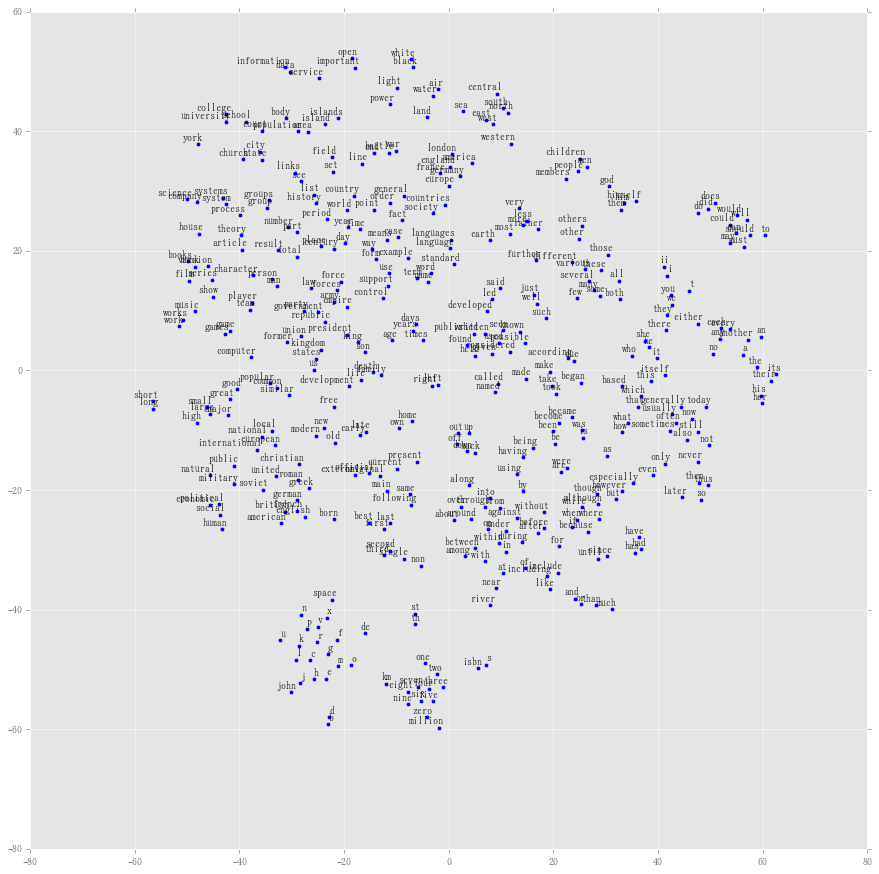

In [110]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(15, 15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')
    plt.show()

words = [reverse_dictionary[i] for i in range(1, num_points + 1)]
plot(two_d_embeddings, words)

## Todo

CBOW

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

## References

- Original [jupyter notebook](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/5_word2vec.ipynb) from the Udacity MOOC course: [Deep learning by Google](https://www.udacity.com/course/deep-learning--ud730).
- [TensorFlow word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)
- http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/